In [15]:
from IPython.display import HTML

In [16]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Synchronizing Noraxon MR3 and Qualsiys QTM

## Purpose

The purpose of this script is to analyze if three systems (Qualisys, 2 x DTS EMG) are synchronized.

## Description ##

*Used Hardware*:

- 1 x Qualisys 4+ camera
- 1 x External Trigger Button
- 1 x 14mm passive marker
- 2 x DRDTS Noraxon EMG
- 1 x 400g DTS accelerometer
- 1 x 24g DTS accelerometer
- 1 x myoSYNC Noraxon

*Setup*:

- Capturing rate
  - Qualisys 4+: 1500Hz/fps (reduced FOV)
  - Noraxon DTS: 1500Hz
- Tracking duration: 
  - 10s = 15000frames 

A wooden block was used to mount marker and accelerometers on it. The Qualisys camera was positioned so it could track the marker during the whole record.

The wooden block stood on a table. It was moved up a little and then moved towards the table surface till it had contact. In theory we should now be able to detect firing of the DTS accelerometers and peak values in the coordinate values of the IR cameras at the very same time, as all systems were set to the same capturing rate.
 
Qualisys was started via an External Trigger Button and the 2 x DTS EMG systems were started in Noraxons MR3 software. The MR3 software was started via Trigger, which came from the Qualisys system. The trigger was received via the myoSYNC, which splitted the signal and forwarded it to both DRDTS.

*Wooden Block with accelerometers and marker attached*
![Wooden Block with accelerometers and marker attached](IMAG0153.jpg)

*View from the Qualisys camera*
![View from the Qualisys camera](IMAG0154.jpg)

## Problem 

The problem is, we only captured the trigger signals for both Noraxon DTS systems. Missing analog input deviced prevented us from tracking the trigger signal in Qualisys QTM. Consequently we will check if all 3 events (peak 2D-coordinate, first rise in acceleration in Z direction DRDTS 1, first rise in acceleration in Z direction DRDTS 2) are captured at the very same time.

## Why are we doing this


A customer wants to capture 32 channels of EMG together with a Qualisys MoCap system. Qualisys can only integrate 16-channels at a maximum. As MR3 is capable of integrating two DRDTS systems we can go up to 32-channels. But now we need to start the system via the external MR3 software and consequently we now have to check of the systems are synchronized correctly. 

In [17]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re

plt.style.use('ggplot')
#%matplotlib notebook

fIDs = {'dts': glob.glob('noraxon\\'+'*.csv'),
        'qtm': glob.glob('qualisys\\'+'*.tsv')
}

fIDs #check if files are correctly imported

{'dts': ['noraxon\\2019-03-20-18-01_sync_test_NOR--QU_0001.csv',
  'noraxon\\2019-03-20-18-02_sync_test_NOR--QU_0002.csv',
  'noraxon\\2019-03-20-18-03_sync_test_NOR--QU_0003.csv',
  'noraxon\\2019-03-20-18-04_sync_test_NOR--QU_0004.csv',
  'noraxon\\2019-03-20-18-04_sync_test_NOR--QU_0005.csv'],
 'qtm': ['qualisys\\sync_test_NOR-QU_0001_2D.tsv',
  'qualisys\\sync_test_NOR-QU_0002_2D.tsv',
  'qualisys\\sync_test_NOR-QU_0003_2D.tsv',
  'qualisys\\sync_test_NOR-QU_0004_2D.tsv',
  'qualisys\\sync_test_NOR-QU_0005_2D.tsv']}

In [18]:
dts_1 = pd.read_csv(fIDs['dts'][0], delimiter=',', skiprows=3)
dts_1.head()

,time,Activity,Marker,Noraxon Desk Receiver-LT Noraxon Desk Receiver.ACCEL 1 Z (G),Noraxon Desk Receiver-Noraxon Desk Receiver.Sync (An),Noraxon Desk Receiver 2-RT Noraxon Desk Receiver 2.ACCEL 1 Z (mG),Noraxon Desk Receiver 2-Noraxon Desk Receiver 2.Sync (An)
0,0.00033,Aktivität,NaN,-0.808741,1,-1048.005615,1
1,0.00100,NaN,NaN,-0.885037,1,-1063.875240,1
2,0.00167,NaN,NaN,-0.869778,1,-1083.712271,1
3,0.00233,NaN,NaN,-0.854518,1,-1103.549303,1
4,0.00300,NaN,NaN,-0.839259,1,-1123.386334,1


In [19]:
qtm_1 = pd.read_csv(fIDs['qtm'][0], delimiter='\t', skiprows=7)
qtm_1.head()

,Frame,Time,Mark1 X,Mark1 Y,Mark1 X Diam,Mark1 Y Diam,Mark2 X,Mark2 Y,Mark2 X Diam,Mark2 Y Diam,Unnamed: 10
0,1,0.00000,70912,38997,2858,2624,NaN,NaN,NaN,NaN,NaN
1,2,0.00067,70916,39000,2946,2688,NaN,NaN,NaN,NaN,NaN
2,3,0.00133,70919,39005,2830,2752,NaN,NaN,NaN,NaN,NaN
3,4,0.00200,70911,39003,2818,2752,NaN,NaN,NaN,NaN,NaN
4,5,0.00267,70914,39000,2818,2624,NaN,NaN,NaN,NaN,NaN


**DTS**

For the DTS-files we will perform the following actions:

- reading in all files
- only read in the columns time, acceleration and sync
- rename to a more readable name
- convert the G accelerometer value to mG

**QTM**

For the QTM-files we will perform the following actions:

- reading in all files
- only read in the columns frame, time, 2d position data of the first marker
- rename to a more readable name

In [20]:
dts, qtm = dict(), dict()
names_dts = [['time', 'Noraxon Desk Receiver-LT Noraxon Desk Receiver.ACCEL 1 Z (G)',
              'Noraxon Desk Receiver-Noraxon Desk Receiver.Sync (An)',
              'Noraxon Desk Receiver 2-RT Noraxon Desk Receiver 2.ACCEL 1 Z (mG)', 
              'Noraxon Desk Receiver 2-Noraxon Desk Receiver 2.Sync (An)'],
             ['accel_1', 'sync_1', 'accel_2', 'sync_2']]
names_qtm = [['Frame', 'Time', 'Mark1 X', 'Mark1 Y'],['frame', 'time', 'x', 'y']]
a=pd.DataFrame()
# load noraxon files
for i, file in enumerate(fIDs['dts']):
    dts[i+1] = pd.read_csv(fIDs['dts'][i], delimiter=',', skiprows=3)
    dts[i+1] = dts[i+1][names_dts[0]].rename(columns={names_dts[0][1]:names_dts[1][0], names_dts[0][2]:names_dts[1][1], 
                                                      names_dts[0][3]:names_dts[1][2], names_dts[0][4]:names_dts[1][3]})
    dts[i+1]['accel_1'] = dts[i+1]['accel_1'] * 1000 #convert from G to mG

# load qualisys files
for j, file in enumerate(fIDs['qtm']):
    qtm[j+1] = pd.read_csv(fIDs['qtm'][j], delimiter='\t', skiprows=7)
    qtm[j+1] = qtm[j+1][names_qtm[0]].rename(columns={'Mark1 X': 'x', 'Mark1 Y' : 'y'})

As a first step for the quality of data, we check the length between qtm and mr3 files

In [21]:
for i in range(len(fIDs['dts'])):
    print("Length Difference of MR3 minus QTM is: %i - %i = %i" %(len(dts[i+1]), len(qtm[i+1]), (len(dts[i+1]) - len(qtm[i+1]))))

Length Difference of MR3 minus QTM is: 15000 - 15000 = 0
Length Difference of MR3 minus QTM is: 15000 - 15000 = 0
Length Difference of MR3 minus QTM is: 15000 - 15000 = 0
Length Difference of MR3 minus QTM is: 15000 - 15000 = 0
Length Difference of MR3 minus QTM is: 15000 - 15000 = 0


As we now know that all files have same length, we can have a look if the sync within the MR3-files can be found at the same point of time. Remember, we measured two DRDTS with MR3 and before checking the sync between MR3 and QTM, we need to verify that both DRDTS received the sync at the same time. If this was not true, we wil shift the data accordingly.

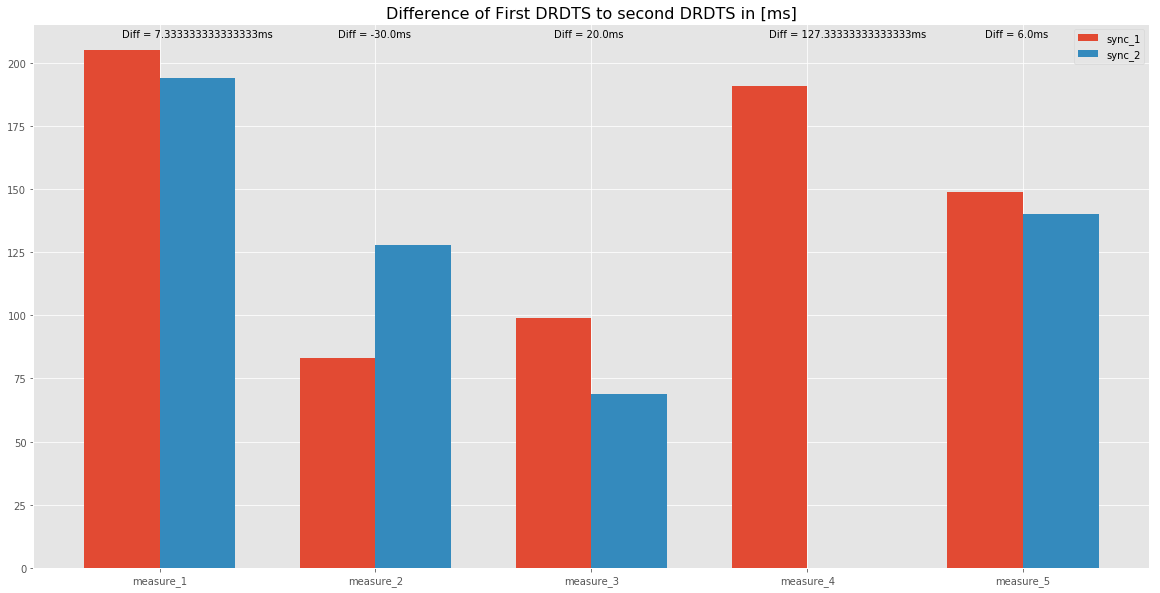

In [22]:
sync_1, sync_2 = [], []

for file in dts:
    data_1 = np.array(dts[file]['sync_1'])
    data_2 = np.array(dts[file]['sync_2'])
    sync_1.append(np.where(data_1==0)[0][0])
    sync_2.append(np.where(data_2==0)[0][0])

# Plot the difference
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Difference of First DRDTS to second DRDTS in [ms]", size=16)
indec = np.arange(len(sync_1))
width = 0.35
ax.bar(indec, sync_1, width, label="sync_1")
ax.bar(indec+width, sync_2, width, label='sync_2')
ax.set_xticks(indec + width/2 )
ax.set_xticklabels(('measure_1', 'measure_2', 'measure_3', 'measure_4', 'measure_5'))
for i in range(5):
    diff = sync_1[i] - sync_2[i]
    plt.text(indec[i], 210, 'Diff = ' + str(diff/1.5) + 'ms') # converted fps to ms
plt.legend()

As we can see all measurements are out of sync. Interestingly at measurement 4 we couldn't capture a sync-signal for the second DRDTS. Maybe this measurement is completely out of sync. We will have a closer look at this one, when comparing to QTM data.

As a next step we will adjust all measurements, so both DRDTS will be in sync over all measurements.

In [23]:
names_1, names_2 = ['time', 'accel_1', 'sync_1'], ['time', 'accel_2', 'sync_2']
dts_1, dts_2 = dict(), dict()
# for the position of the fall of the sync we will refer to the sync_1, sync_2 variable from above

for file in dts:
    dts_1[file] = dts[file][names_1].iloc[sync_1[file-1]::].reset_index()
    dts_2[file] = dts[file][names_2].iloc[sync_2[file-1]::].reset_index()

# for file in dts: # just naming the dict entries
#     dts_1[file] = dts[file][names_1]
#     dts_2[file] = dts[file][names_2]

Now that we have everything in sync, let's have a grapical look at our complete dataset.

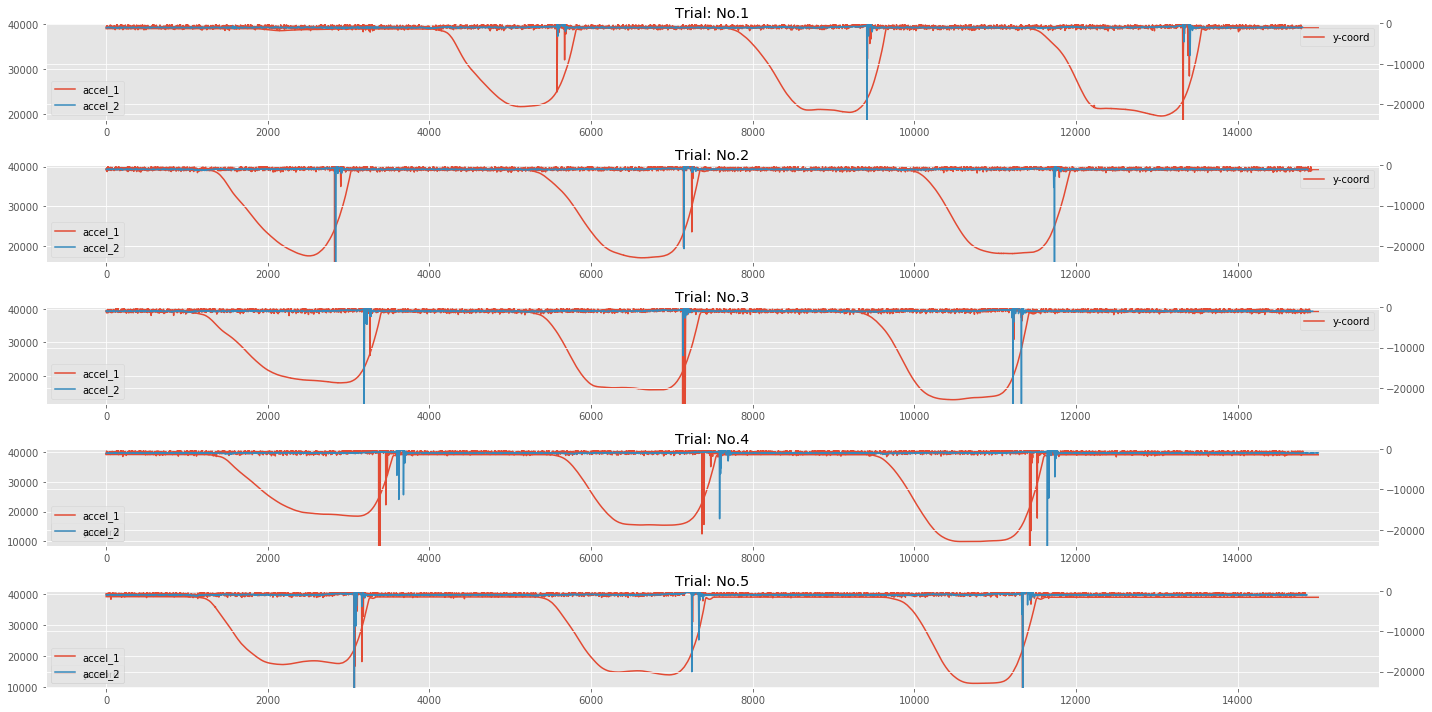

In [24]:
fig = plt.figure(figsize=(20,10))

for k in qtm:
    ax1 = fig.add_subplot(5,1,k)
    ax1.plot(qtm[k]['y'], label='y-coord')
    ax2 = ax1.twinx()
    ax2.set_ylim([-24000,0])
    ax2.plot(dts_1[k]['accel_1'], label='accel_1')
    ax2.plot(dts_2[k]['accel_2'], label='accel_2')
    ax1.legend(), ax2.legend()
    ax1.set_title("Trial: No." + str(k))
plt.tight_layout()

From the plot above we can see that there seems to be a time difference between the accelerometer signals from the DTS and the QTM position data. We will now develop an algorithm that gives us the peaks of the QTM position and the DTS acceleration accordingly.

We can see a plot of the QTM peaks below.

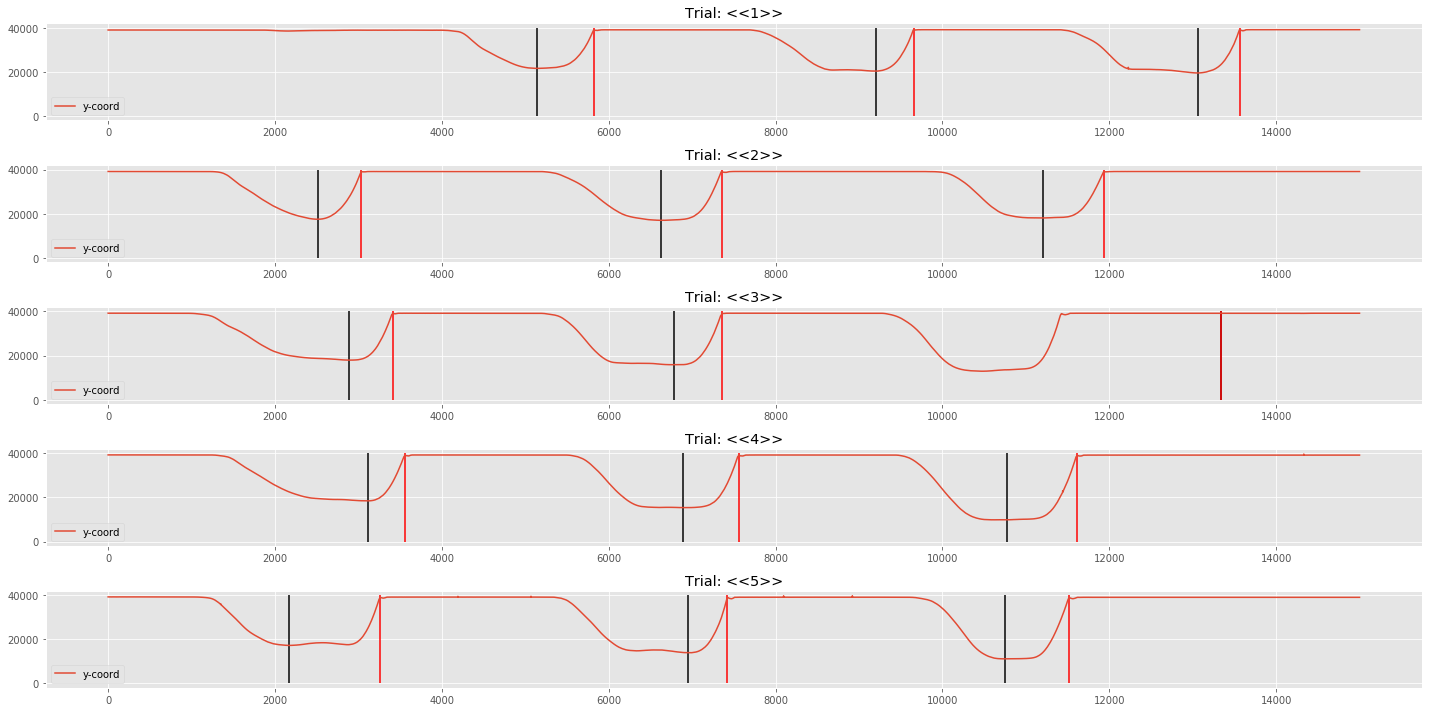

In [25]:
from scipy.signal import find_peaks, argrelmin, argrelextrema


#>>>>>>>>>>>>>>>>>>>> START first_peaks <<<<<<<<<<<<<<<<<<<<<<<<<<
def first_peaks(dict_data, col, height,start=0):
    '''
    finding the first instance of peaks in a signal
    '''
    peaks = list()
    for i in range(5):
        pos, val = find_peaks(dict_data[i+1][col].iloc[start:].abs(), height=height)
        peak = [pos[0]]
        #print(pos)
        for j,num in enumerate(pos):
            if pos[j] > peak[-1]+1500: #only take the next peak of the next movement; 1500 = a second after the first peak
                peak.append(pos[j]) 
        if len(peak) > 3:
            print('DTS-Warning: more than 3 (%i) peaks detected!' %(len(peak)))
        peaks.append(peak)
    
    return np.array(peaks) # return list of sublists with all peaks
#>>>>>>>>>>>>>>>>>>>> END first_peaks <<<<<<<<<<<<<<<<<<<<<<<<<<


fig1 = plt.figure(figsize=(20,10) )

# Finding the peaks in QTM position data
qtm_peaks = list()
for file in qtm:
    # find minimum of y-coordinate (lifted block); we cut files by 1500 frames as it positively impacts the peak finding
    minima = argrelextrema(np.array(qtm[file]['y'].iloc[:-1500]), np.less, order=1500)
    peaks = []
    for minimum in minima[0]:
        first_peak,_ = find_peaks(qtm[file]['y'].iloc[minimum:minimum+1500], height=38000) #from minimum search for first peak within a second
        peaks.append(first_peak[0]+minimum) #add minimum for correct index value of original df
    qtm_peaks.append(peaks)
    if len(peaks) != 3:
            print('QTM-Warning @file %i: n=%i peaks detected!' %(file, len(peaks)))

    ax1 = fig1.add_subplot(5,1,file)
    ax1.plot(qtm[file]['y'], label='y-coord')
    ax1.vlines(minima[0], ymin=0, ymax=40000)
    ax1.vlines(peaks, ymin=0, ymax=40000, color='red')
    ax1.legend()
    ax1.set_title("Trial: <<%s>>" %str(file))
    
plt.tight_layout()
    
qtm_peaks = np.array(qtm_peaks)
dts_1_peaks = first_peaks(dts_1, 'accel_1', 2800)
dts_2_peaks = first_peaks(dts_2, 'accel_2', 2800)
    

As we can see from the plot above, the last peak in Trial **3** is not correctly set. We will ignore it in both QTM and DTS data and will proceed with further calculations: subtracting the peaks from each other.

As the QTM system worked as the master device we will subtract the DTS peaks from the QTM peaks.

## Results

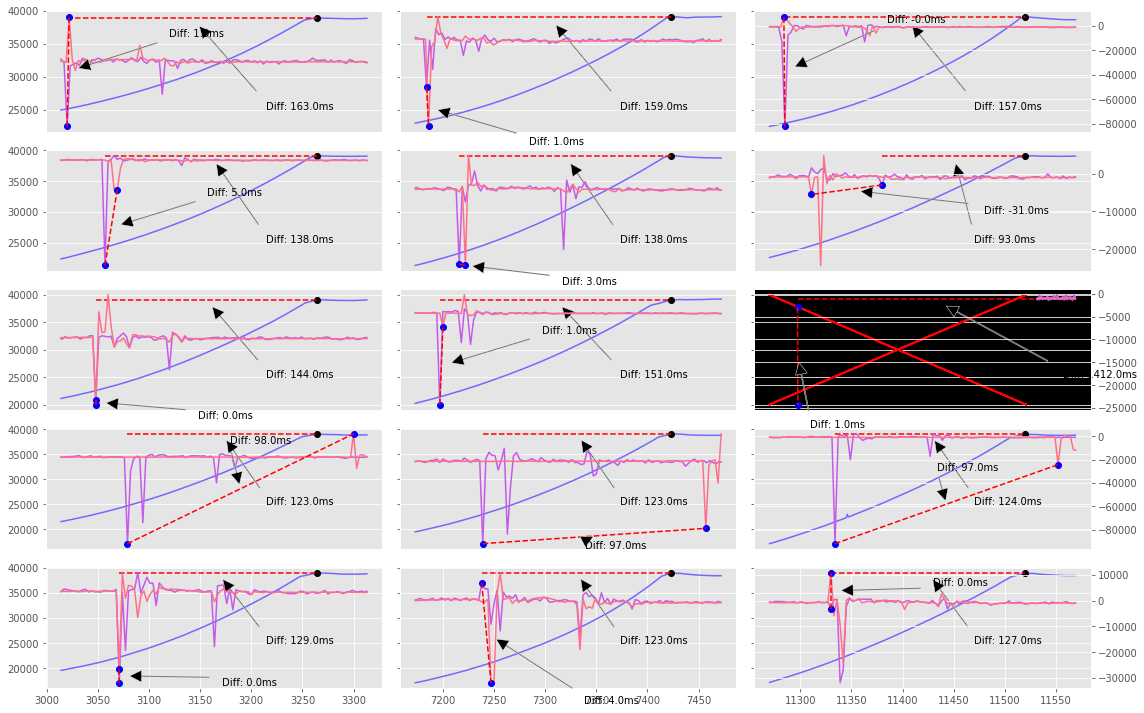

In [26]:
# compute distances between the peaks
diff_qtm_dts1 = (qtm_peaks - dts_1_peaks) * 1/1.5 # convert to ms
diff_qtm_dts2 = (qtm_peaks - dts_2_peaks) * 1/1.5
diff_qtm_both = (diff_qtm_dts1 - diff_qtm_dts2) * 1/1.5

fig, ax = plt.subplots(5, 3, sharey='row', figsize=(16,10))
number = 0
for file in qtm:
    for h, value in enumerate(diff_qtm_dts1[file-1]):
        number += 1
        ax2 = ax[file-1, h].twinx()
        middle = qtm_peaks[file-1, h]
        # plot data
        accel_1, accel_2 = dts_1[file]['accel_1'], dts_2[file]['accel_2']
        position = qtm[file]['y']
        ax[file-1, h].plot(position.iloc[middle-250:middle+50], c='#7069FF')
        ax2.plot(accel_1.iloc[middle-250:middle+50], c='#C55AE8')
        ax2.plot(accel_2.iloc[middle-250:middle+50], c='#FF7088')
        
        #plot peaks as dots
        x_a1, x_a2, x_qu = dts_1_peaks[file-1, h], dts_2_peaks[file-1, h], qtm_peaks[file-1, h]
        y_a1, y_a2, y_qu = accel_1.iloc[x_a1], accel_2.iloc[x_a2], position.iloc[x_qu]
        ax[file-1, h].plot(x_qu, y_qu, 'o', c='black')
        ax2.plot(x_a1, y_a1, 'o', c='blue')
        ax2.plot(x_a2, y_a2, 'o', c='blue')
        
        # draw line and annotate delta_t
        ax[file-1, h].plot([x_a1, x_qu], [y_qu, y_qu], '--', c='red')
        ax[file-1, h].annotate("Diff: %sms" %str(diff_qtm_dts1[file-1, h].round()), xy=((x_qu+x_a1)/2, (y_qu+y_qu)/2), 
                               xytext=(x_qu - 50, 25000), arrowprops=dict(facecolor='black', shrink=0.1, width=1))
        ax2.plot([x_a1, x_a2], [y_a1, y_a2], '--', c='red')
        ax2.annotate("Diff: %sms" %str(diff_qtm_both[file-1, h].round()), xy=((x_a1+x_a2)/2, (y_a1+y_a2)/2),
                     xytext=(x_a1+100, y_a2 -5000), arrowprops=dict(facecolor='black', shrink=0.1, width=1))
        
        # beautify the plot
        if file != 5:
            ax[file-1, h].axes.get_xaxis().set_ticks([])
        if h != 2:
            ax2.axes.get_yaxis().set_ticks([])
        
        # 
        ax[2,2].set_facecolor('black')
        ax[2,2].plot([11000, 13000], [40000, 20000], c='red')
        ax[2,2].plot([11000, 13000], [20000, 40000], c='red')
        
plt.tight_layout()

Here is the table of the time difference between *DTS_1* and *QTM*

In [27]:
diff_qtm_dts1

array([[ 162.66666667,  159.33333333,  156.66666667],
       [ 138.        ,  138.        ,   93.33333333],
       [ 144.        ,  150.66666667, 1412.        ],
       [ 123.33333333,  122.66666667,  124.        ],
       [ 128.66666667,  123.33333333,  126.66666667]])

There are some findings from the plot and the table above (not considering Event Number 3 of Trials 2 and 3):

- the DTS data is leading the QTM data with a time difference within a range of 122ms and 163ms
- this time difference is stable within the trials
- when not considering Trial 4 (the one where *DTS_2* didn't show a falling flank), both *DTS-systems* show a valid synchronisation 
- for Trial 4 the *DTS_2* seems to be completely out of sync; the *DTS_1* shows a time difference within the above reported range

Here is the table of time difference between *DTS_1* and *DTS_2*. All values for time differences are in *milliseconds*

## Discussion

Sometimes our algorithm fails to detect the correct peaks, due to variabel data. A more reliable approach would be to detect the event of an analog Trigger Button in Both systems (this was technically not possible here). 

As a general result we can state that the DTS systems are both in sync, but both are **not** in sync with the QTM data. One reason for the DTS data being out of sync might be because we didn't use the correct sync setting, as MR3 gave out an error that no sync-signal has been received. In general it seems that MR3 didn't capture all data, as the sync channel never shows a rising flank.

Though the sync-channel never showing a rising flank might also be related to USB-delay of the capture. Evidence for this lies in the variable time diffetence of the DTS to the QTM system [122ms, 163ms], as USB delay is never constant. The USB delay of over 100ms would be large in general, but we have to consider that the QTM cameras are connected via an Ethernet connection and the DTS system is connected via an USB2.0 port. Also there are keyboards that show 25ms USB delay, and these are not as complex as EMG system. 

We will try the same setup again with two different synchronization settings:

- inverting the sync signal at the external sync in port of the Noraxon myoSYNC
- using the Sync Out port of the Qualisys camera for starting the measurement in MR3